In [ ]:
!pip install timm
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from timm.utils import ModelEmaV3
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

#positional embeddings
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        t = t.long().to(self.embeddings.device)
        embeds = self.embeddings[t].to(x.device)
        embeds = torch.reshape(embeds, (1,-1))
        return embeds[:, :, None]

In [2]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [3]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        length = x.shape[2]
        x = rearrange(x, 'b c l -> b l c')
        x = self.proj1(x)
        x = rearrange(x, 'b l (C H K) -> K b H l C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H l C -> b l (C H)')
        x = self.proj2(x)
        return rearrange(x, 'b l C -> b C l')

In [4]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            last_layer: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale and not last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1, output_padding=1)
        elif last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1)
        else:
            self.conv = nn.Conv1d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        #print(x.shape, self.conv(x).shape)
        return self.conv(x), x

In [5]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            last_layers: List = [False, False, False, False, False, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv1d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv1d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv1d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                last_layer=last_layers[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            residual = residuals[self.num_layers - i - 1]
            x = torch.concat((layer(x, embeddings)[0], residual), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [6]:
model = UNET()

# Generate a random 1D input tensor of shape (batch_size, input_channels, length)
batch_size = 1  # You can change this to whatever batch size you need
input_length = 31  # As specified
input_tensor = torch.randn(batch_size, 1, input_length)  # Shape: (1, 1, 31)

# Generate a random time step tensor
time_steps = torch.randint(0, 1000, (batch_size,))  # Randomly generating time steps

# Pass the input tensor through the model
output = model(input_tensor, time_steps)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 31])


In [ ]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False).cuda()
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False).cuda()

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [ ]:
#data = np.load('/home/nnara/notebooks/pixel_data')
#data = np.load('/content/1mil_pixel_data.npy')
data = np.load('/content/columbia_pixel_data.npy')
#reshape it to (size, channels, length)
data = data.reshape((-1, 1, 31))

In [ ]:
class SpectralDataset(Dataset):
  def __init__(self, data):
    self.data = torch.from_numpy(data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
import os
#batch size must be compatible with number of data points (999,990)
def train(batch_size: int=246,
          num_time_steps: int=1000,
          num_epochs: int=1,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          checkpoint_path: str=None):
    #set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = SpectralDataset(data)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_dataloader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (999990/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    #torch.save(checkpoint, '/home/nnara/checkpoints/ddpm_checkpoint.pth')
    torch.save(checkpoint, '/content/ddpm_checkpoint.pth')

In [ ]:
#train(checkpoint_path='/home/nnara/checkpoints/ddpm_checkpoint.pth', lr=2e-5, num_epochs=10)
train(checkpoint_path='/content/ddpm_checkpoint.pth', lr=2e-5, num_epochs=1)

Epoch 1/1: 100%|██████████| 4065/4065 [05:13<00:00, 12.96it/s]


Epoch 1 | Loss 1.25225


In [ ]:
#base class for different tasks like super resolution, denoising, inpainting, etc.
class H_functions:
    """
    A class replacing the SVD of a matrix H, perhaps efficiently.
    All input vectors are of shape (Batch, ...).
    All output vectors are of shape (Batch, DataDimension).
    """

    def V(self, vec):
        """
        Multiplies the input vector by V
        """
        raise NotImplementedError()

    def Vt(self, vec):
        """
        Multiplies the input vector by V transposed
        """
        raise NotImplementedError()

    def U(self, vec):
        """
        Multiplies the input vector by U
        """
        raise NotImplementedError()

    def Ut(self, vec):
        """
        Multiplies the input vector by U transposed
        """
        raise NotImplementedError()

    def singulars(self):
        """
        Returns a vector containing the singular values. The shape of the vector should be the same as the smaller dimension (like U)
        """
        raise NotImplementedError()

    def add_zeros(self, vec):
        """
        Adds trailing zeros to turn a vector from the small dimension (U) to the big dimension (V)
        """
        raise NotImplementedError()

    def H(self, vec):
        """
        Multiplies the input vector by H
        """
        temp = self.Vt(vec)
        singulars = self.singulars()
        return self.U(singulars * temp[:, :singulars.shape[0]])

    def Ht(self, vec):
        """
        Multiplies the input vector by H transposed
        """
        temp = self.Ut(vec)
        singulars = self.singulars()
        return self.V(self.add_zeros(singulars * temp[:, :, :singulars.shape[0]]))

    def H_pinv(self, vec):
        """
        Multiplies the input vector by the pseudo inverse of H
        """
        temp = self.Ut(vec)
        singulars = self.singulars()
        temp[:, :, :singulars.shape[0]] = temp[:, :, :singulars.shape[0]] / singulars
        return self.V(self.add_zeros(temp))

In [ ]:
class Denoising(H_functions):
    def __init__(self, target_db, num_wavelengths=31):
        """
        Initialize the HFunctions class.

        Args:
            target_db (int): Level of noise (10, 20, 30, or 40)
            num_wavelengths (int): Total number of wavelengths (default: 31).
        """
        self.target_db = target_db
        self.num_wavelengths = num_wavelengths
        #singulars are not used here, so they are initialized to ones
        self._singulars = torch.ones(31).cuda()

    def H(self, x):
        #using signal to noise ratio formula: SNR = 10*log 10 (signal power / noise power)
        signal_power = torch.mean(x ** 2) #signal power is squared mean value of input spectral wave
        noise_power = signal_power / (10 ** (self.target_db / 10)) #compute noise power using SNR formula
        noise = torch.randn_like(x) * torch.sqrt(noise_power)
        return x + noise

    def Ht(self, y): #just returns the noised input since no transformation is needed since we aren't using SVD
        return y

    def H_pinv(self, y): #same as above
        return y

    def V(self, vec):
        return vec

    def Vt(self, vec):
        return vec

    def U(self, vec):
        return vec

    def Ut(self, vec):
        return vec

    def singulars(self):
        return self._singulars

    def add_zeros(self, vec):
        return vec

In [ ]:
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).cuda(), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1)
    return a

def ddrm_inference(
    checkpoint_path,
    x,      # Input data point (1x31 vector)
    seq,    # Sequence of timesteps for sampling
    H_funcs,
    sigma_0=0.1,  # Noise threshold
    etaB=0.85,    # Noise handling for more noisy components
    etaA=0.5,     # Noise handling for less noisy components
    etaC=0.5      # Noise handling more missing/highly corrupted components
):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=0.9999)
    ema.load_state_dict(checkpoint['ema'])

    # Set the model to evaluation mode to disable dropout and batch normalization training behaviors
    model.eval()

    # Convert input to torch tensor and move to GPU
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    x = x.cuda()
    #add noise
    x = H_funcs.H(x)

    # Create beta schedule matching your training scheduler
    b = torch.linspace(1e-4, 0.02, 1000).to(x.device)

    with torch.no_grad():
        # Setup for DDRM sampling
        # In this case, this is a tensor of ones since I'm not using SVD
        singulars = H_funcs.singulars()

        # Create a zero tensor to store singular values
        # This is a placeholder that matches the dimension of your input
        Sigma = torch.zeros(x.shape[2], device=x.device)
        Sigma[:singulars.shape[0]] = singulars

        # Store the original noisy input
        y_0 = x.clone()

        # Transform the input using the Ut (U transpose) operation
        # This projects the input into a different space
        U_t_y = H_funcs.Ut(y_0)

        # Divide by singular values (which are 1s in your case)
        Sig_inv_U_t_y = U_t_y / singulars[:U_t_y.shape[-1]]

        # Compute the largest alphas for the final timestep
        # This determines the noise level at the start of reverse diffusion
        largest_alphas = compute_alpha(b, (torch.ones(x.size(0)) * seq[-1]).to(x.device).long())

        # Calculate sigmas based on alphas
        # This represents the noise standard deviation
        largest_sigmas = (1 - largest_alphas).sqrt() / largest_alphas.sqrt()

        # Identify significant singular values based on noise threshold
        # In this case, this will mostly just select all indices
        large_singulars_index = torch.where(singulars * largest_sigmas[0, 0, 0] > sigma_0)

        # Create a tensor to store inverse of singular values
        inv_singulars_and_zero = torch.zeros(x.shape[2]).to(singulars.device)
        inv_singulars_and_zero[large_singulars_index] = sigma_0 / singulars[large_singulars_index]
        inv_singulars_and_zero = inv_singulars_and_zero.view(1, -1)

        # Initialize the first estimate of the reconstructed signal
        init_y = torch.zeros(x.shape[0], x.shape[2]).to(x.device)

        # Project the initial estimate using U transpose
        init_y[:, large_singulars_index[0]] = U_t_y[:, :, large_singulars_index[0]] / singulars[large_singulars_index].view(1, -1)
        init_y = init_y.view(*x.size())

        # Compute remaining sigma (noise standard deviation)
        remaining_s = largest_sigmas.view(-1, 1) ** 2 - inv_singulars_and_zero ** 2
        remaining_s = remaining_s.view(x.shape[0], x.shape[2]).clamp_min(0.0).sqrt()

        # Combine initial estimate with original input
        init_y = init_y + remaining_s * x
        init_y = init_y / largest_sigmas

        # Transform the initial estimate using V operation
        x = H_funcs.V(init_y.view(x.size(0), -1)).view(*x.size())

        # Setup iteration variables
        n = x.size(0)
        # Create a sequence of previous timesteps
        seq_next = [-1] + list(seq[:-1])
        # List to store predictions of x0 at each step
        x0_preds = []
        # List to store noisy samples at each step
        xs = [x]

        # Iterate over timesteps in reverse order
        for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
            # Convert timesteps to tensors
            t = (torch.ones(n) * i).to(x.device)
            next_t = (torch.ones(n) * j).to(x.device)

            # Compute alphas for current and next timesteps
            at = compute_alpha(b, t.long())
            at_next = compute_alpha(b, next_t.long())

            # Get current noisy sample
            xt = xs[-1].to('cuda')

            # Predict noise using the model
            et = model(xt, t)

            # Predict x0 (clean signal) using the noise prediction
            x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()

            # Compute sigmas for current and next timesteps
            sigma = (1 - at).sqrt()[0, 0, 0] / at.sqrt()[0, 0, 0]
            sigma_next = (1 - at_next).sqrt()[0, 0, 0] / at_next.sqrt()[0, 0, 0]

            # Normalize current sample
            xt_mod = xt / at.sqrt()[0, 0, 0]

            # Transform current and x0 samples
            V_t_x = H_funcs.Vt(xt_mod)
            SVt_x = (V_t_x * Sigma)[:, :U_t_y.shape[2]]

            V_t_x0 = H_funcs.Vt(x0_t)
            SVt_x0 = (V_t_x0 * Sigma)[:, :U_t_y.shape[2]]

            # Prepare conditions for different noise scenarios
            falses = torch.zeros(V_t_x0.shape[2] - singulars.shape[0], dtype=torch.bool, device=xt.device)
            cond_before_lite = singulars * sigma_next > sigma_0
            cond_after_lite = singulars * sigma_next < sigma_0
            cond_before = torch.hstack((cond_before_lite, falses))
            cond_after = torch.hstack((cond_after_lite, falses))

            # Compute noise parameters for different scenarios
            std_nextC = sigma_next * etaC
            sigma_tilde_nextC = torch.sqrt(sigma_next ** 2 - std_nextC ** 2)

            std_nextA = sigma_next * etaA
            sigma_tilde_nextA = torch.sqrt(sigma_next**2 - std_nextA**2)

            diff_sigma_t_nextB = torch.sqrt(sigma_next ** 2 - sigma_0 ** 2 / singulars[cond_before_lite] ** 2 * (etaB ** 2))

            # Initial modification of next prediction
            Vt_xt_mod_next = V_t_x0 + sigma_tilde_nextC * H_funcs.Vt(et) + std_nextC * torch.randn_like(V_t_x0)

            # Modify prediction for less noisy components
            Vt_xt_mod_next[:, :, cond_after] = \
                V_t_x0[:, :, cond_after] + sigma_tilde_nextA * ((U_t_y - SVt_x0) / sigma_0)[:, :, cond_after_lite] + std_nextA * torch.randn_like(V_t_x0[:, :, cond_after])

            # Modify prediction for more noisy components
            Vt_xt_mod_next[:, :, cond_before] = \
                (Sig_inv_U_t_y[:, :, cond_before_lite] * etaB + (1 - etaB) * V_t_x0[:, :, cond_before] + diff_sigma_t_nextB * torch.randn_like(U_t_y)[:, :, cond_before_lite])

            # Transform back to original space
            xt_mod_next = H_funcs.V(Vt_xt_mod_next)
            xt_next = (at_next.sqrt()[0, 0, 0] * xt_mod_next).view(*x.shape)

            # Store predictions
            x0_preds.append(x0_t.to('cpu'))
            xs.append(xt_next.to('cpu'))

    return xs, x0_preds

In [ ]:
#ddrm_inference('/home/nnara/checkpoints/ddpm_checkpoint.pth')
data = np.load('/content/columbia_pixel_data.npy')
seq = list(range(0, 1000, 50))
H_funcs = Denoising(target_db=10)
true_waves = []
preds = []

for i in range(3):
  rand = random.randint(0,32000)
  x = data[rand].reshape(1, -1, 31)
  predictions = ddrm_inference('/content/ddpm_checkpoint.pth', x, seq, H_funcs, 0.05, 0.9, 0.3, 0.5)
  true_waves.append(x)
  preds.append(predictions[0])

20it [00:01, 17.73it/s]
20it [00:00, 108.85it/s]
20it [00:00, 117.31it/s]


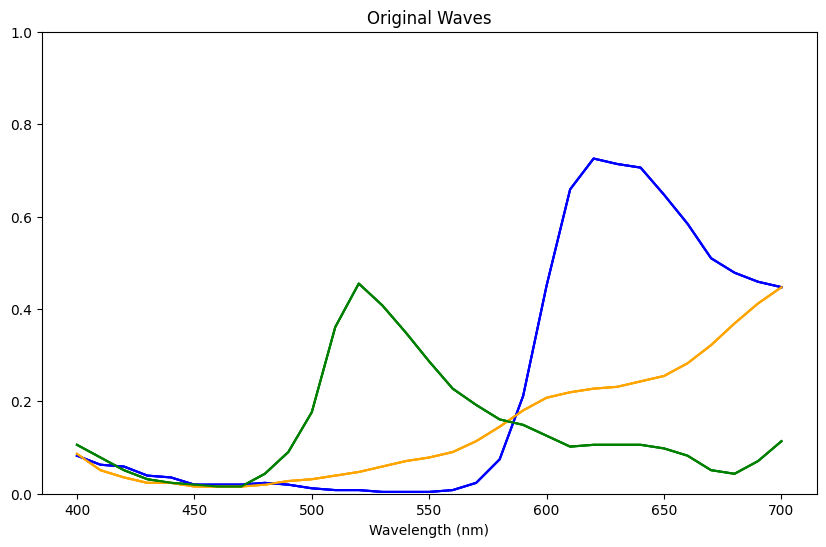

In [ ]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for x in true_waves:
  for i, wave in enumerate(true_waves):
      wave = wave.squeeze()
      #plt.plot(range(420,721,10), wave, color=colors[i % len(colors)])
      plt.plot(range(400,701,10), wave, color=colors[i % len(colors)])

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Original Waves");

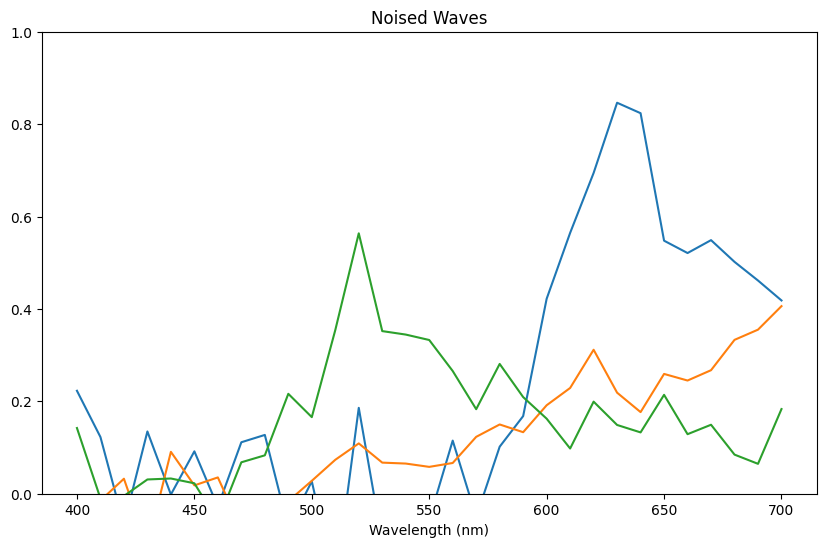

In [ ]:
plt.figure(figsize=(10, 6))

for pred in preds:
  for i, p in enumerate(pred[0]):
      p = p.squeeze()
      #plt.plot(range(420,721,10), p.cpu())
      plt.plot(range(400,701,10), p.cpu())

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Noised Waves");

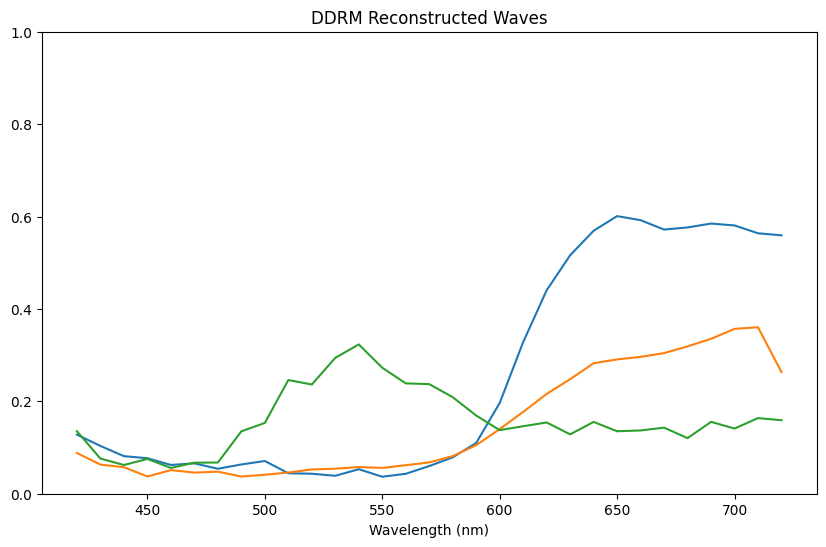

In [ ]:
plt.figure(figsize=(10, 6))

for pred in preds:
  for i, p in enumerate(pred[-1]):
      p = p.squeeze()
      plt.plot(range(420,721,10), p.cpu())

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("DDRM Reconstructed Waves");

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.9 MB/s eta 0:00:00


In [ ]:
import pywt
noised_waves = [pred[0].reshape(-1,31).cpu() for pred in preds]
[i.shape for i in noised_waves]

[torch.Size([1, 31]), torch.Size([1, 31]), torch.Size([1, 31])]

In [ ]:
def bayes_threshold(coeffs):
    sigma_sq = np.var(coeffs)
    return sigma_sq / np.sqrt(max(sigma_sq - np.var(coeffs), 1e-6))

def wavelet_denoise(signal, wavelet='db4', level=2, threshold_method='soft'):
    """
    Denoise a 1D spectral signal using wavelet thresholding.

    Parameters:
    - signal: 1D NumPy array (1x31)
    - wavelet: Wavelet type (default='db4')
    - level: Decomposition level (default=2)
    - threshold_method: 'soft' or 'hard' thresholding

    Returns:
    - denoised_signal: Reconstructed denoised signal (1x31)
    """

    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    thresholds = [bayes_threshold(c) for c in coeffs[1:]]

    # Apply adaptive thresholding to detail coefficients
    new_coeffs = [coeffs[0]]  # Keep approximation coefficients
    for i, c in enumerate(coeffs[1:]):
        new_coeffs.append(pywt.threshold(c, thresholds[i], mode=threshold_method))
    denoised_signal = pywt.waverec(new_coeffs, wavelet)

    # Trim to original length (waverec may return a slightly longer array)
    return denoised_signal[:, :signal.shape[-1]]

In [ ]:
wavelet_denoised = []
for wave in noised_waves:
  denoised = wavelet_denoise(wave)
  wavelet_denoised.append(denoised)

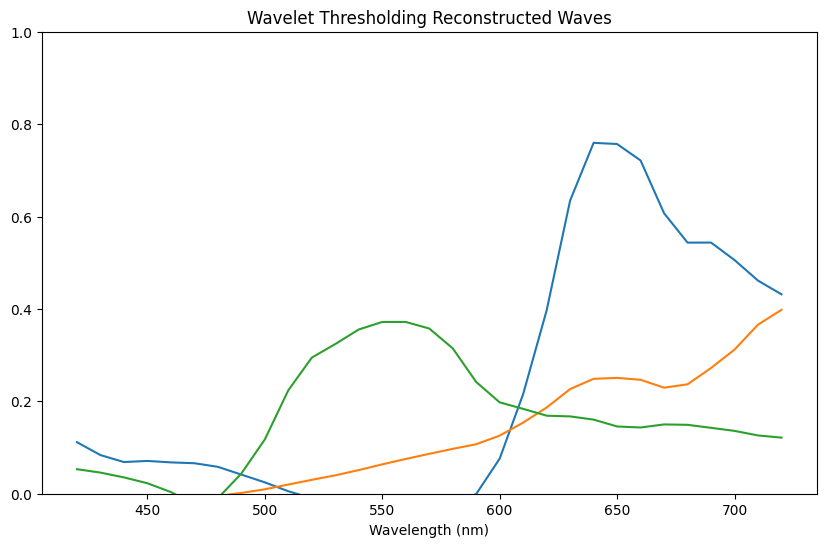

In [ ]:
plt.figure(figsize=(10, 6))

for wave in wavelet_denoised:
  for point in wave:
      plt.plot(range(420,721,10), point)

plt.ylim(0,1)
plt.xlabel("Wavelength (nm)")
plt.title("Wavelet Thresholding Reconstructed Waves");

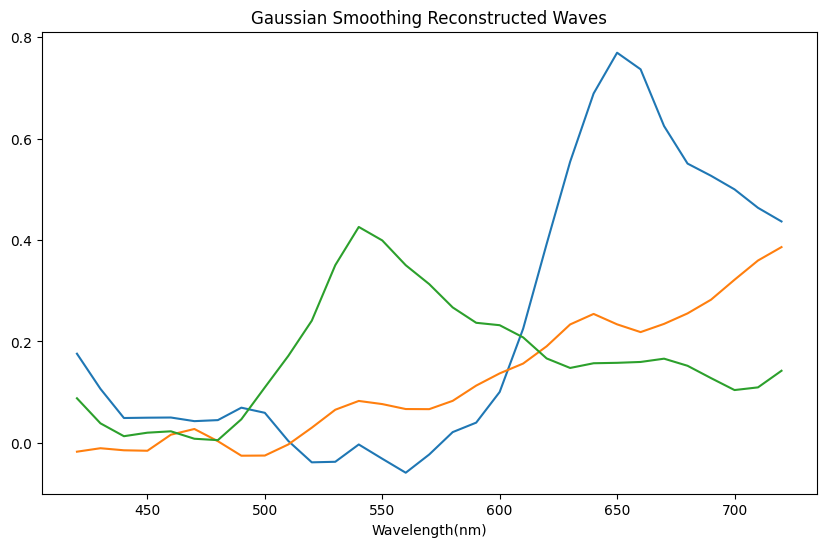

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(10, 6))

# Apply Gaussian smoothing with standard deviation (sigma)
sigma = 1
for wave in noised_waves:
  smoothed_wave = gaussian_filter1d(wave, sigma)
  for point in smoothed_wave:
    plt.plot(range(420,721,10), point)
plt.title("Gaussian Smoothing Reconstructed Waves")
plt.xlabel("Wavelength(nm)");

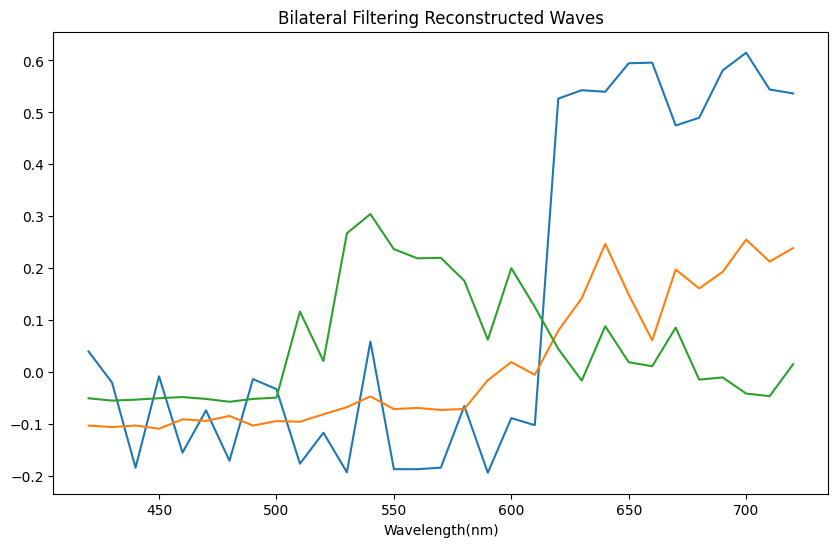

In [ ]:
import numpy as np
from skimage.restoration import denoise_bilateral

plt.figure(figsize=(10, 6))

for wave in noised_waves:
  wave = np.array(wave)
  denoised = denoise_bilateral(wave, sigma_color=0.1, sigma_spatial=2).reshape(1,31)
  for point in denoised:
    plt.plot(range(420,721,10), point)
plt.title("Bilateral Filtering Reconstructed Waves")
plt.xlabel("Wavelength(nm)");

In [ ]:
def mse(actual, pred):
  actual = np.array(actual) if not isinstance(actual, np.ndarray) else actual
  pred = np.array(pred) if not isinstance(pred, np.ndarray) else pred
  errors = np.abs((actual - pred)**2)
  return np.mean(errors)

def DDRMreconstruction(seq, H_funcs, sigma_0, etaB, etaA, etaC):
  accuracies = []
  wave_indices = [random.randint(0,32000) for i in range(100)]
  for target_db in [40, 30, 20, 10]:
    H_funcs = Denoising(target_db=target_db)
    true_waves = []
    preds = []
    for i in wave_indices:
      x = data[i].reshape(1, -1, 31)
      predictions = ddrm_inference('/content/ddpm_checkpoint.pth', x, seq, H_funcs, sigma_0, etaB, etaA, etaC)
      true_waves.append(x)
      preds.append(predictions[0])
    #calculate average mae across the 100 reconstructions
    errors = []
    for i in range(100):
      actual = true_waves[i]
      pred = preds[i][-1]
      error = mse(actual, pred)
      errors.append(error)
    average_mse = np.mean(errors)
    accuracies.append((target_db, average_mse))
  return accuracies

In [ ]:
seq = list(range(0, 1000, 50))
H_funcs = Denoising(target_db=10)
accuracies = DDRMreconstruction(seq, H_funcs, 0.05, 0.9, 0.3, 0.5)

20it [00:00, 102.94it/s]
20it [00:00, 104.34it/s]
20it [00:00, 115.67it/s]
20it [00:00, 105.49it/s]
20it [00:00, 116.50it/s]
20it [00:00, 108.28it/s]
20it [00:00, 81.97it/s]
20it [00:00, 76.33it/s]
20it [00:00, 76.00it/s]
20it [00:00, 111.57it/s]
20it [00:00, 111.29it/s]
20it [00:00, 116.84it/s]
20it [00:00, 112.30it/s]
20it [00:00, 116.96it/s]
20it [00:00, 111.70it/s]
20it [00:00, 114.79it/s]
20it [00:00, 113.83it/s]
20it [00:00, 109.65it/s]
20it [00:00, 116.42it/s]
20it [00:00, 105.85it/s]
20it [00:00, 114.81it/s]
20it [00:00, 105.27it/s]
20it [00:00, 115.51it/s]
20it [00:00, 112.93it/s]
20it [00:00, 115.55it/s]
20it [00:00, 108.88it/s]
20it [00:00, 115.94it/s]
20it [00:00, 114.55it/s]
20it [00:00, 114.83it/s]
20it [00:00, 111.53it/s]
20it [00:00, 80.84it/s]
20it [00:00, 88.32it/s]
20it [00:00, 73.92it/s]
20it [00:00, 114.77it/s]
20it [00:00, 111.74it/s]
20it [00:00, 108.83it/s]
20it [00:00, 111.15it/s]
20it [00:00, 109.08it/s]
20it [00:00, 113.74it/s]
20it [00:00, 116.44it/s]
20it [

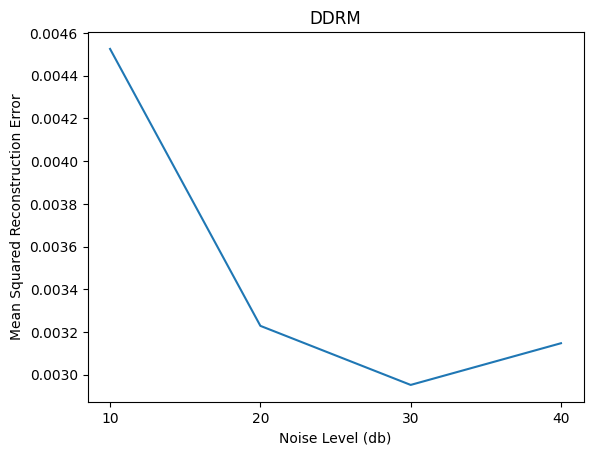

In [ ]:
DDRM_x_vals = [i for (i,j) in accuracies]
DDRM_y_vals = [j for (i, j) in accuracies]
plt.plot(DDRM_x_vals, DDRM_y_vals)
plt.title("DDRM")
plt.ylabel("Mean Squared Reconstruction Error")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

In [ ]:
def WaveletReconstruction(wavelet='db4', level=2, threshold_method='soft'):
  accuracies = []
  wave_indices = [random.randint(0,32000) for i in range(100)]
  for target_db in [40, 30, 20, 10]:
    true_waves = []
    preds = []
    for i in wave_indices:
      x = data[i].reshape(-1, 31)
      signal_power = np.mean(x ** 2) #signal power is squared mean value of input spectral wave
      noise_power = signal_power / (10 ** (target_db / 10)) #compute noise power using SNR formula
      noise = np.random.randn(*x.shape) * np.sqrt(noise_power)
      x = x + noise
      predictions = wavelet_denoise(x, wavelet, level, threshold_method)
      true_waves.append(x)
      preds.append(predictions)
    #calculate average mse across the 100 reconstructions
    errors = []
    for i in range(100):
      actual = true_waves[i]
      pred = preds[i]
      error = mse(actual, pred)
      errors.append(error)
    average_mse = np.mean(errors)
    accuracies.append((target_db, average_mse))
  return accuracies

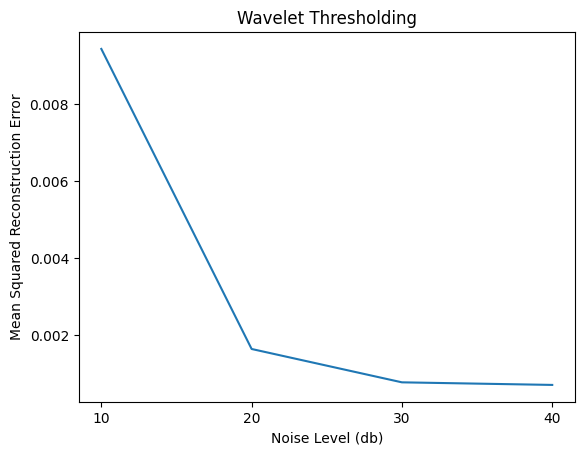

In [ ]:
accuracies = WaveletReconstruction()
WR_x_vals = [i for (i,j) in accuracies]
WR_y_vals = [j for (i, j) in accuracies]
plt.plot(WR_x_vals, WR_y_vals)
plt.title("Wavelet Thresholding")
plt.ylabel("Mean Squared Reconstruction Error")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

In [ ]:
def GaussianReconstruction(sigma=1):
  accuracies = []
  wave_indices = [random.randint(0,32000) for i in range(100)]
  for target_db in [40, 30, 20, 10]:
    true_waves = []
    preds = []
    for i in wave_indices:
      x = data[i].reshape(-1, 31)
      signal_power = np.mean(x ** 2) #signal power is squared mean value of input spectral wave
      noise_power = signal_power / (10 ** (target_db / 10)) #compute noise power using SNR formula
      noise = np.random.randn(*x.shape) * np.sqrt(noise_power)
      x = x + noise
      predictions = gaussian_filter1d(x, sigma)
      true_waves.append(x)
      preds.append(predictions)
    #calculate average mae across the 100 reconstructions
    errors = []
    for i in range(100):
      actual = true_waves[i]
      pred = preds[i]
      error = mse(actual, pred)
      errors.append(error)
    average_mse = np.mean(errors)
    accuracies.append((target_db, average_mse))
  return accuracies

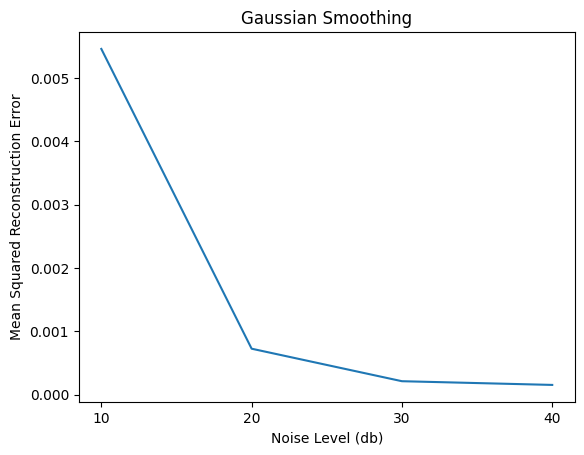

In [ ]:
accuracies = GaussianReconstruction()
GS_x_vals = [i for (i,j) in accuracies]
GS_y_vals = [j for (i, j) in accuracies]
plt.plot(GS_x_vals, GS_y_vals)
plt.title("Gaussian Smoothing")
plt.ylabel("Mean Squared Reconstruction Error")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

In [ ]:
def BilateralReconstruction(sigma_color=0.1, sigma_spatial=2):
  accuracies = []
  wave_indices = [random.randint(0,32000) for i in range(100)]
  for target_db in [40, 30, 20, 10]:
    true_waves = []
    preds = []
    for i in wave_indices:
      x = data[i].reshape(-1, 31)
      signal_power = np.mean(x ** 2) #signal power is squared mean value of input spectral wave
      noise_power = signal_power / (10 ** (target_db / 10)) #compute noise power using SNR formula
      noise = np.random.randn(*x.shape) * np.sqrt(noise_power)
      x = np.array(x + noise)
      predictions = denoise_bilateral(x, sigma_color=sigma_color, sigma_spatial=sigma_spatial, bins=100).reshape(1,31)
      true_waves.append(x)
      preds.append(predictions)
    #calculate average mae across the 100 reconstructions
    errors = []
    for i in range(100):
      actual = true_waves[i]
      pred = preds[i]
      error = mse(actual, pred)
      errors.append(error)
    average_mse = np.mean(errors)
    accuracies.append((target_db, average_mse))
  return accuracies

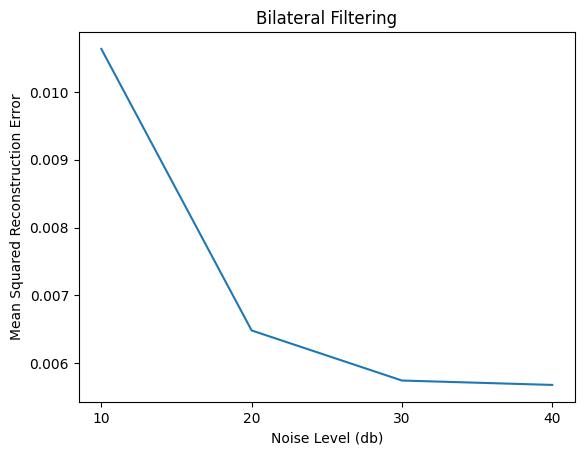

In [ ]:
accuracies = BilateralReconstruction()
BR_x_vals = [i for (i,j) in accuracies]
BR_y_vals = [j for (i, j) in accuracies]
plt.plot(BR_x_vals, BR_y_vals)
plt.title("Bilateral Filtering")
plt.ylabel("Mean Squared Reconstruction Error")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);

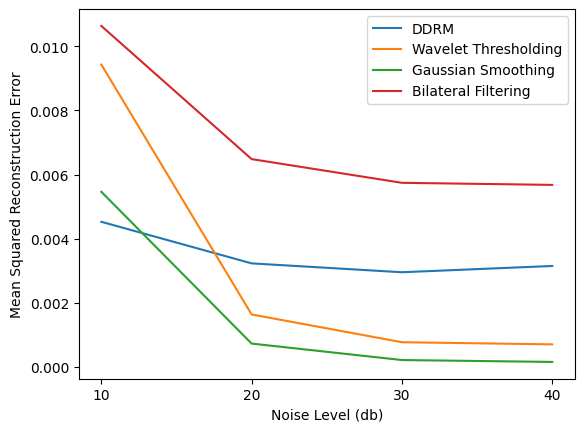

In [ ]:
x = [DDRM_x_vals, WR_x_vals, GS_x_vals, BR_x_vals]
y = [DDRM_y_vals, WR_y_vals, GS_y_vals, BR_y_vals]
labels = ["DDRM", "Wavelet Thresholding", "Gaussian Smoothing", "Bilateral Filtering"]
for i in range(len(x)):
  plt.plot(x[i], y[i], label=labels[i])

plt.legend()
plt.ylabel("Mean Squared Reconstruction Error")
plt.xlabel("Noise Level (db)")
plt.xticks([10,20,30,40]);